In [8]:
import sys
from pathlib import Path
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [11]:
# Get the absolute path of the parent directory
# parent_dir = str(Path(__file__).resolve().parent.parent)

parent_dir = str(Path().cwd().parent)

# Add the parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Now you can import the module as if it was in the same directory
import utils.aadt_predictor as ap

## Load the Data

In [13]:
HPMS_DIR = Path('../../data/processed_data/HPMS')
RANDOM_STATE = 42
RESPONSE_VARS = ['AADT_MDV', 'AADT_HDV']
RF_PREDICTOR_VARS = ["STATEFP", "COUNTYFP", "F_SYSTEM", "THROUGH_LANES", "AADT"]

predictor = ap.AADTPredictor(HPMS_DIR / 'hpms_aadt_subset.csv', None, random_state = RANDOM_STATE)

Loading data from ..\..\data\processed_data\HPMS\hpms_aadt_subset.csv


c:\Users\achawla1\Desktop\work\NearRoadExposure\scripts\utils\aadt_predictor.py:37: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data_full = pd.read_csv(self.data_path)


Full Data loaded successfully: 6598607 rows and 17 columns.
Pre-processing data...
ERROR: The data could not be subsetted. [None]
ERROR: The data could not be loaded. 'NoneType' object has no attribute 'shape'


In [14]:
response_var = RESPONSE_VARS[0]

predictor.response_var = response_var
predictor.subset_train_data()
predictor.split_data(RF_PREDICTOR_VARS, state_fips= None, test_size=1e-10)

Training Data subsetted successfully with AADT_MDV: 4766630 rows and 17 columns.
Training and testing data split with test size 1e-10 on State None and not stratified ...


In [15]:
X, y = predictor.X_train, predictor.y_train

In [19]:
# Define the parameter space for the Random Forest
param_space = {
    'n_estimators': Integer(10, 100),
    'max_depth': Integer(5, 50),
    'min_samples_split': Real(0.01, 0.1),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical([None, 'sqrt', 'log2'])
}

# Create a Random Forest Regressor
rf = RandomForestRegressor(random_state=RANDOM_STATE)

In [20]:
# Setup the BayesSearchCV with the parameter space and the regressor
opt = BayesSearchCV(
    estimator=rf,
    search_spaces=param_space,
    n_iter=32,
    cv=3,  # Number of cross-validation folds
    n_jobs=-1,  # Number of jobs to run in parallel
    random_state=42
)

In [21]:
# Fit the model
opt.fit(X, y)

BayesSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_iter=32,
              n_jobs=-1, random_state=42,
              search_spaces={'max_depth': Integer(low=5, high=50, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=(None, 'sqrt', 'log2'), prior=None),
                             'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'min_samples_split': Real(low=0.01, high=0.1, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=100, prior='uniform', transform='normalize')})

In [22]:
# Best model found
print("Best parameters found:", opt.best_params_)
print("Best cross-validation score:", opt.best_score_)

Best parameters found: OrderedDict([('max_depth', 50), ('max_features', None), ('min_samples_leaf', 1), ('min_samples_split', 0.01), ('n_estimators', 100)])
Best cross-validation score: 0.7288894671331966


In [23]:
# show trajectory of search
results = opt.cv_results_

In [26]:
opt.best_estimator_

RandomForestRegressor(max_depth=50, max_features=None, min_samples_split=0.01,
                      random_state=42)

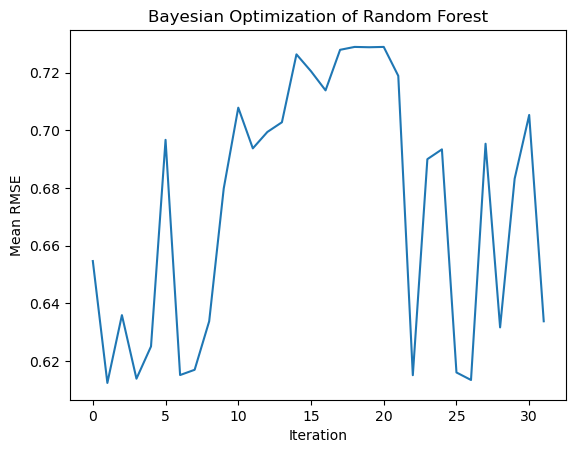

In [25]:
# visualize rmse over iterations
import matplotlib.pyplot as plt
plt.plot(results['mean_test_score'])
plt.xlabel('Iteration')
plt.ylabel('Mean RMSE')
plt.title('Bayesian Optimization of Random Forest')
plt.show()